# 16. QLS - Violations of Regression Models

When using regression to fit a model, the assumptions of regression analysis must be satisfied to ensure good parameter estimates and accurate statistics. Parameters need to be:

- unbiased (expected value over different samples is the true value)
- consistent (converging to the true value with many samples)
- efficient (minimized variance)

Here we'll see in which ways these assumptions are violated, and the effect on parameters and statistics. For the examples, we'll use single-variable linear equations, but the considerations still apply to other models. We also assume the model is correctly specified: that the functional form is valid.

## Focus on the residuals

Rather than focusing on model construction, it's possible to gain information from errors. The model might be complex and impossible to analyze, but as long as there are predictions and observed values, residuals can be computed.

If these residuals don't follow a given distribution then something is wrong and the predictions might not be accurate.

### Non-normally distributed residuals

If the error term is not normally distributed, then the statistical significance will be off. The Central Limit Theorem (CLT) states that for large enough samples the coefficient distributions will be close to normal even if the errors aren't. Therefore, the analysis is still valid for large datasets.

In [135]:
import numpy as np
import pandas as pd
import seaborn as sb
sb.set(rc={'figure.figsize':(11.7,8.27)})
sb.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
import statsmodels
import statsmodels.api as sm
from statsmodels import regression, stats
import yfinance as yf

#### Testing for normality

A good test for normality is the Jarque-Bera test.

In [136]:
residuals = np.random.normal(0, 1, 100)
_, pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(residuals)
print(pvalue)

residuals = np.random.poisson(size = 100)
_, pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(residuals)
print(pvalue)

0.3793335312001061
0.014879993723917878


## Heteroskedasticity

This means the variance of the error terms is not constant across observations. Meaning the observations aren't distributed uniformly across the regression line.

This is common in cross-sectional data where the differences in the samples measured lead to differences in the variance.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     9739.
Date:                Fri, 28 Jul 2023   Prob (F-statistic):          6.73e-100
Time:                        02:28:55   Log-Likelihood:                -247.37
No. Observations:                 100   AIC:                             498.7
Df Residuals:                      98   BIC:                             504.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8966      0.576      1.557      0.123      -0.246       2.039
x1             0.9916      0.010     98.685      0.000       0.972       1.012
==============================================================================
Omnibus:                        0.395   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.375
Skew:                          -0.143   Prob(JB):                        0.829
Kurtosis:                       2.909   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

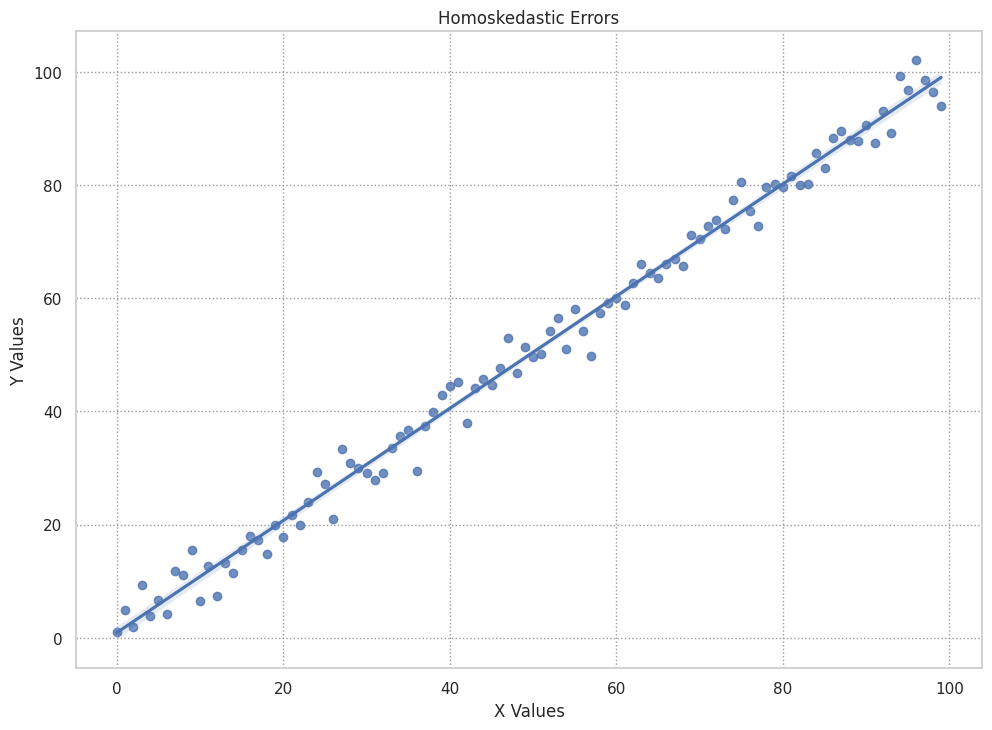

In [137]:
# create synthetic dataset with constant variance around a line
xs = np.arange(100)
y1 = xs + 3*np.random.randn(100)

# get results of linear regression
slr1 = regression.linear_model.OLS(y1, sm.add_constant(xs)).fit()

# construct the fit line
fit1 = slr1.params[0] + slr1.params[1]*xs

# plot data and regression line
sb.regplot(x=xs, y=y1).set(title="Homoskedastic Errors", xlabel="X Values", ylabel="Y Values")

# plot result summary
slr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     122.3
Date:                Fri, 28 Jul 2023   Prob (F-statistic):           6.24e-19
Time:                        02:28:56   Log-Likelihood:                -475.67
No. Observations:                 100   AIC:                             955.3
Df Residuals:                      98   BIC:                             960.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2861      5.646     -0.405      0.686     -13.491       8.918
x1             1.0895      0.099     11.058      0.000       0.894       1.285
==============================================================================
Omnibus:                        2.650   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.266   Jarque-Bera (JB):                2.346
Skew:                          -0.114   Prob(JB):                        0.309
Kurtosis:                       3.715   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

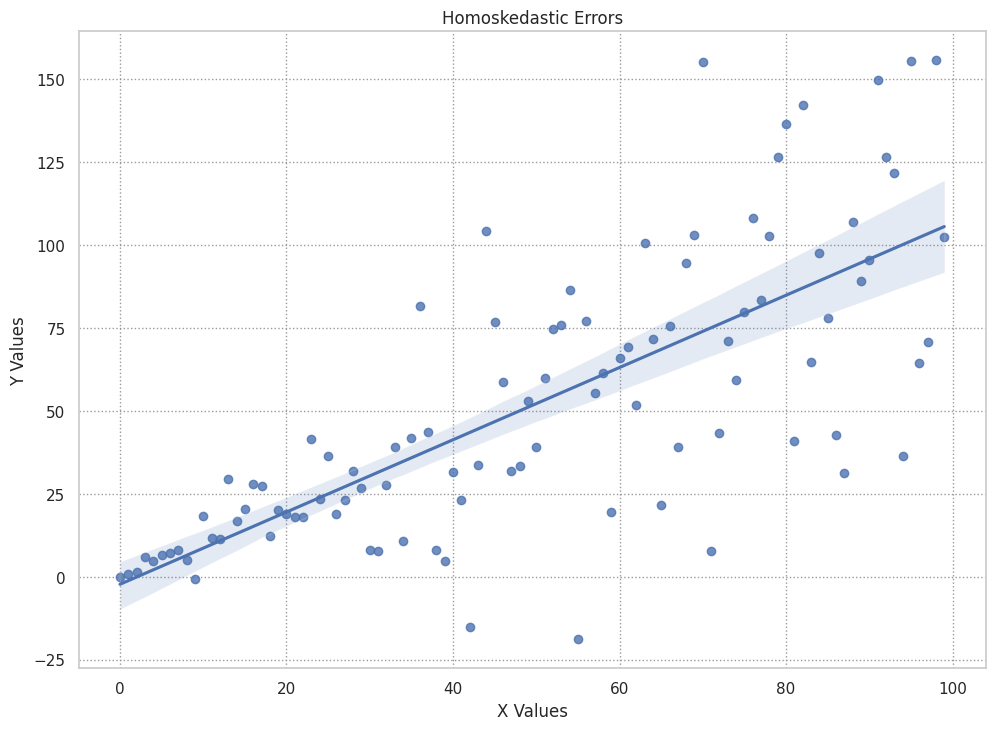

In [138]:
# create synthetic dataset with constant variance around a line
y2 = xs*(1 + .5*np.random.randn(100))

# get results of linear regression
slr2 = regression.linear_model.OLS(y2, sm.add_constant(xs)).fit()

# construct the fit line
fit2 = slr2.params[0] + slr2.params[1]*xs

# plot data and regression line
sb.regplot(x=xs, y=y2).set(title="Homoskedastic Errors", xlabel="X Values", ylabel="Y Values")

# plot result summary
slr2.summary()

### Testing for Heteroskedasticity

Using the *Breush Pagan* test is very valuable for this. Testing for normality also detects the weirdness in the second case. **However**, it must be noted that normally distributed residuals can still be heteroskedastic, so both tests must be performed.

In [139]:
residuals1 = y1-fit1
residuals2 = y2-fit2

xs_with_constant = sm.add_constant(xs)

_, jb_pvalue1, _, _ = statsmodels.stats.stattools.jarque_bera(residuals1)
_, jb_pvalue2, _, _ = statsmodels.stats.stattools.jarque_bera(residuals2)

_, pvalue1, _, _ = stats.diagnostic.het_breuschpagan(residuals1, xs_with_constant)
_, pvalue2, _, _ = stats.diagnostic.het_breuschpagan(residuals2, xs_with_constant)

print("P-Value for 'residuals1' being normal", jb_pvalue1)
print("P-Value for 'residuals1' being heteroskedastic", pvalue1)
print("P-Value for 'residuals2' being normal", jb_pvalue2)
print("P-Value for 'residuals2' being heteroskedastic", pvalue2)

P-Value for 'residuals1' being normal 0.8288888720999076
P-Value for 'residuals1' being heteroskedastic 0.5386149802103255
P-Value for 'residuals2' being normal 0.3094666240693186
P-Value for 'residuals2' being heteroskedastic 3.4864594669853504e-05


### Correcting for Heteroskedasticity

How does heteroskedasticity affect our analysis? This problematic situation -conditional heteroskedasticity- is when the error variance is correlated with the independent variables. This makes the F-test for regression significance,and the T-test for the significances of individual coefficients unreliable. More often this results in overestimation of the significance of the fit.

The *Breuch-Pagan* test and the *White test* can be used to detect this. If there are suspicions that this is present, the model can be altered to correct for this. One method is generalized least squares, which requires a manual alteration. Another is computing robust standard errors, which corrects the fit statistics to account for heteroskedasticity. Note the difference in the statistics below:

In [140]:
slr2.summary()
slr2.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     126.8
Date:                Fri, 28 Jul 2023   Prob (F-statistic):           2.29e-19
Time:                        02:28:56   Log-Likelihood:                -475.67
No. Observations:                 100   AIC:                             955.3
Df Residuals:                      98   BIC:                             960.6
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2861      3.480     -0.657      0.513      -9.192       4.620
x1             1.0895      0.097     11.260      0.000       0.897       1.282
==============================================================================
Omnibus:                        2.650   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.266   Jarque-Bera (JB):                2.346
Skew:                          -0.114   Prob(JB):                        0.309
Kurtosis:                       3.715   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

## Serial correlation of errors
A common and serious problem is when errors are correlated across observations -serial correlation/autocorrelation- since this can occur when some of the data points are related, or when the timeseries data has periodic fluctuations. If one of the independent variables depends on previous values of the dependent variable (or if incorrect model specification leads to autocorrelation) then the coefficient estimates will be invalid. Otherwise, the parameter estimates will be valid, but the fit statistics will be off. E.g. if the correlation is positive, the F-test and T-Statistics will be inflated, leading to overestimating the significance of the model.

If errors are homoskedastic, testing for autocorrelation can be done using the *Dublin-Watson* test, which is reported in the summary in `statsmodels`.

[*********************100%***********************]  1 of 1 completed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     507.7
Date:                Fri, 28 Jul 2023   Prob (F-statistic):           3.93e-62
Time:                        02:28:57   Log-Likelihood:                -583.00
No. Observations:                 252   AIC:                             1170.
Df Residuals:                     250   BIC:                             1177.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.6448      0.309     89.609      0.000      27.037      28.252
x1             0.0479      0.002     22.532      0.000       0.044       0.052
==============================================================================
Omnibus:                       30.510   Durbin-Watson:                   0.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.725
Skew:                          -0.750   Prob(JB):                     1.94e-10
Kurtosis:                       4.418   Cond. No.                         289.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

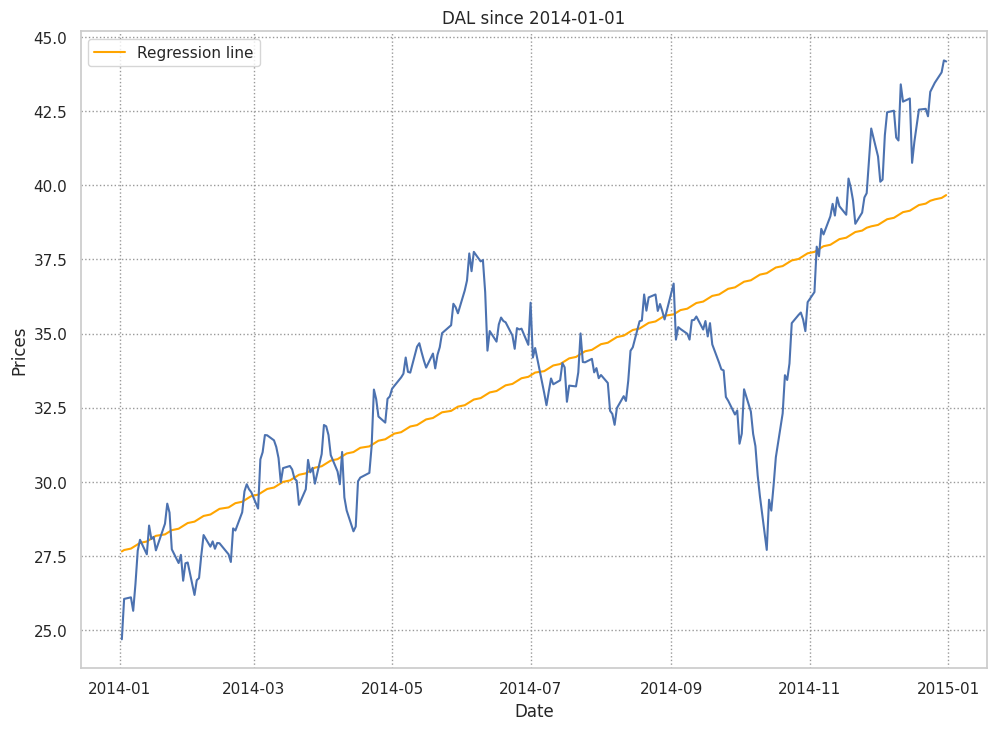

In [141]:
# load pricing data
start = "2014-01-01"
end = "2015-01-01"
y = yf.download("DAL", start, end)
y = y["Adj Close"]
x = np.arange(len(y))

# regress pricing data against time
model = regression.linear_model.OLS(y, sm.add_constant(x)).fit()

# construct the fit line
prediction = model.params[0] + model.params[1]*x
sb.lineplot(x=y.index, y=prediction, label="Regression line", color="orange")
sb.lineplot(x=y.index, y=y).set(title=f"DAL since {start}", xlabel="Date", ylabel="Prices")

# print summary
model.summary()

### Testing for Autocorrelation

Testing can be done in both prices and residuals by using the *Ljun-Box* test. This computes the probability that the n-th lagged datapoint is predictive of the current. If no max lag is given, the function computes a max lag and returns the p-values for all lags up to that one. For the 5 most recent datapoints, a significant correlation exists with the current. Therefore, both the data is autocorrelated.

In [142]:
_, prices_qstats, prices_qstats_pvalues = sm.tsa.stattools.acf(y, nlags=40,qstat=True, fft=True)
_, prices_qstats, prices_qstats_pvalues = sm.tsa.stattools.acf(y-prediction, nlags=40 ,qstat=True, fft=True)

print("Price autocorrelation p-values", prices_qstats_pvalues)
print("Residuals autocorrelation p-values", prices_qstats_pvalues)

_, jb_value, _, _ = statsmodels.stats.stattools.jarque_bera(y-prediction)

print("JB p-value that residuals are normally distributed", jb_value)

Price autocorrelation p-values [8.84136774e-052 5.65413905e-096 9.54978147e-136 8.25119022e-172
 3.49573591e-204 1.31969972e-232 1.14552959e-257 9.32286732e-280
 1.87500040e-299 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
Residuals autocorrelation p-values [8.84136774e-052 5.65413905e-096 9.54978147e-136 8.25119022e-172
 3.49573591e-204 1.31969972e-232 1.14552959e-257 9.32286732e-280
 1.87500040e-299 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.0000

#### Newey-West

It's a method of computing variance that accounts for autocorrelation. A naive variance computation will produce inaccurate standard errors with the presence of autocorrelation.

To eliminate serial correlation the regression equation must be changed. A simpler fix is adjusting the standard errors using an appropriate method and using those values to check for significance. For positively correlated errors, it's expected for the standard errors to be higher than those reported by the regression.

In [143]:
from math import sqrt

# find the covariance matrix of the coefficients
cov_mat = stats.sandwich_covariance.cov_hac(model)

# print the standard errors of each coefficient from the original and the adjustment
print("Old standard errors:", model.bse[0], model.bse[1])
print("Adj standard errors:", sqrt(cov_mat[0,0]), sqrt(cov_mat[1,1]))

Old standard errors: 0.3085049362716867 0.002126752193153602
Adj standard errors: 0.4546173877382352 0.004604941271040426


## Multicollinearity

When using multiple independent variables, it's important to check for an approximate linear relation between the independent variables, like so:

$$X_{2} \approx 5X_{1} - X_{3} + 4.5$$

With multicollinearity, it's difficult to identify the independent effect of each variable, since the coefficients can be changed around according to the linear relation without changing the model. As with unnecessary variables, this won't hurt the accuracy, but will cloud the analysis. The estimated coefficients will have large standard errors. The coefficients won't represent the partial effect of each variable, since multicollinearity doesn't allow change on one variable **while** keeping the others constant.

High correlation of independent variables is indicative of multicollinearity. However, it isn't enough, since there is a need to detect correlation between one of the variables and a linear combination of the others. If there is a high $R^{2}$ but low T-statistics on the coefficients (the fit is good but the estimates aren't precise) there might be multicollinearity. To solve this, one of the independent variables in the linear relation needs to be dropped.

E.g. using two stock indices as the independent variables is likely to lead to multicollinearity. Below, it's shown how removing one of them improves the T-statistics without hurting the $R^{2}$.

Another important thing to determine is which variable may be the causal one. If there is a hypothesis that the market influences MDY and HPQ, then the market is the variable that should be used in the predictive model.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
R-Squared: 0.902469405284055
T-Statistics of coefficients:
 const   -11.782175
x1       23.780533
x2       -4.501918
dtype: float64


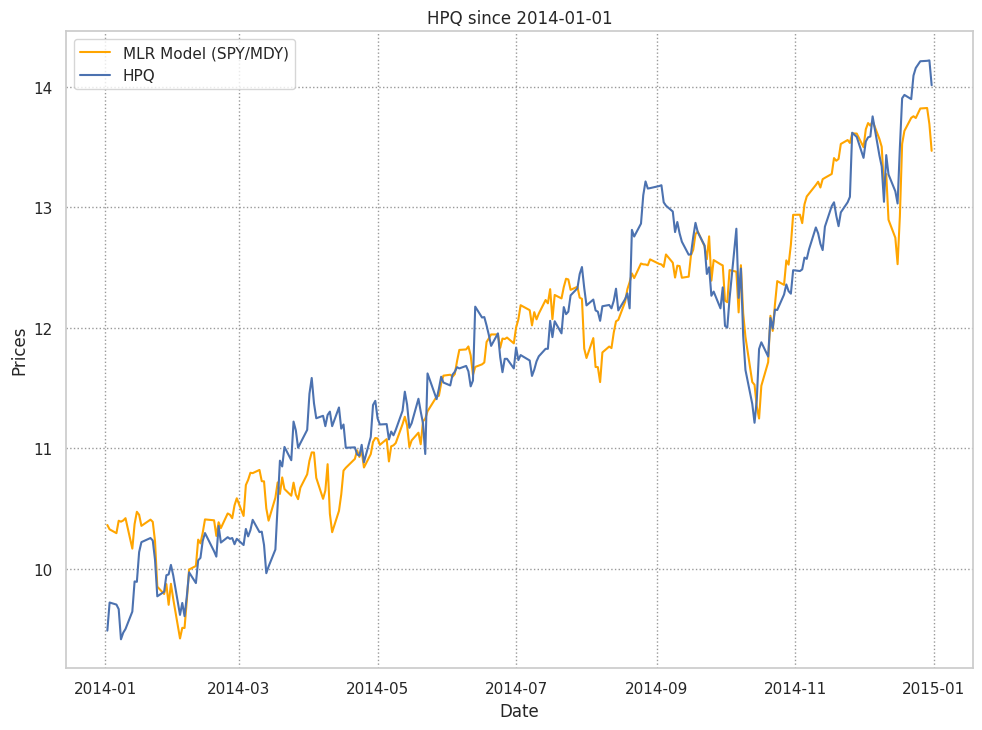

In [144]:
# load pricing data for an asset and two indices
start = "2014-01-01"
end = "2015-01-01"

b1 = yf.download("SPY", start, end)
b2 = yf.download("MDY", start, end)
a = yf.download("HPQ", start, end)

# format data
b1 = b1["Adj Close"]
b2 = b2["Adj Close"]
a = a["Adj Close"]

# run multiple linear regression
mlr = regression.linear_model.OLS(a, sm.add_constant(np.column_stack((b1,b2)))).fit()

# construct fit curve using dependent variables and estimated coefficients
mlr_prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2

# print regression stats
print("R-Squared:", mlr.rsquared_adj)
print("T-Statistics of coefficients:\n", mlr.tvalues)

# plot asset and model
sb.lineplot(mlr_prediction, label="MLR Model (SPY/MDY)", color="orange")
sb.lineplot(a, label="HPQ").set(title=f"HPQ since {start}", xlabel="Date", ylabel="Prices");

R-Squared: 0.8949528145074911
T-Statistics of coefficients:
 const       -23.071555
Adj Close    46.253675
dtype: float64


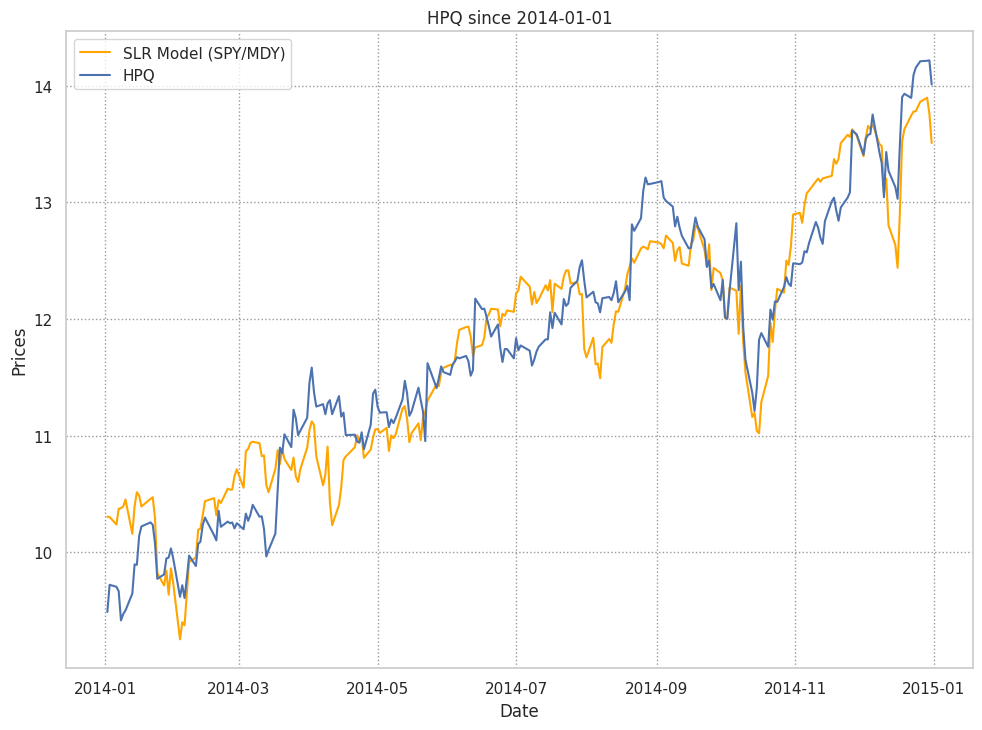

In [145]:
# perform linear regression
slr = regression.linear_model.OLS(a, sm.add_constant(b1)).fit()
slr_prediction = slr.params[0] + slr.params[1]*b1

# print fit stats
print("R-Squared:", slr.rsquared_adj)
print("T-Statistics of coefficients:\n", slr.tvalues)

# plot asset and model
sb.lineplot(slr_prediction, label="SLR Model (SPY/MDY)", color="orange")
sb.lineplot(a, label="HPQ").set(title=f"HPQ since {start}", xlabel="Date", ylabel="Prices");

## Example: Anscombe's Quartet

Anscombe constructed four datasets which have the same mean, variance, correlation coefficient, regression line, and R-Squared regression value in each variable. Below, the results are tested, and plotted. A quick glance shows that only the first dataset satisfies the regression model assumptions; the high R-Squared value of the other three are not meaningful, which agrees with the intuition that the other three aren't modeled well by the lines of best fit.

/home/hooregi/documents/projects/quantopian_lectures/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Coefficients: [3.000090909090908, 0.5000909090909091] [3.0009090909090905, 0.5] [3.0024545454545444, 0.49972727272727263] [3.001727272727269, 0.49990909090909097]
Pearson r: 0.81642051634484 0.8162365060002427 0.8162867394895982 0.8165214368885029
R-squared: 0.666542459508775 0.6662420337274844 0.6663240410665593 0.6667072568984652


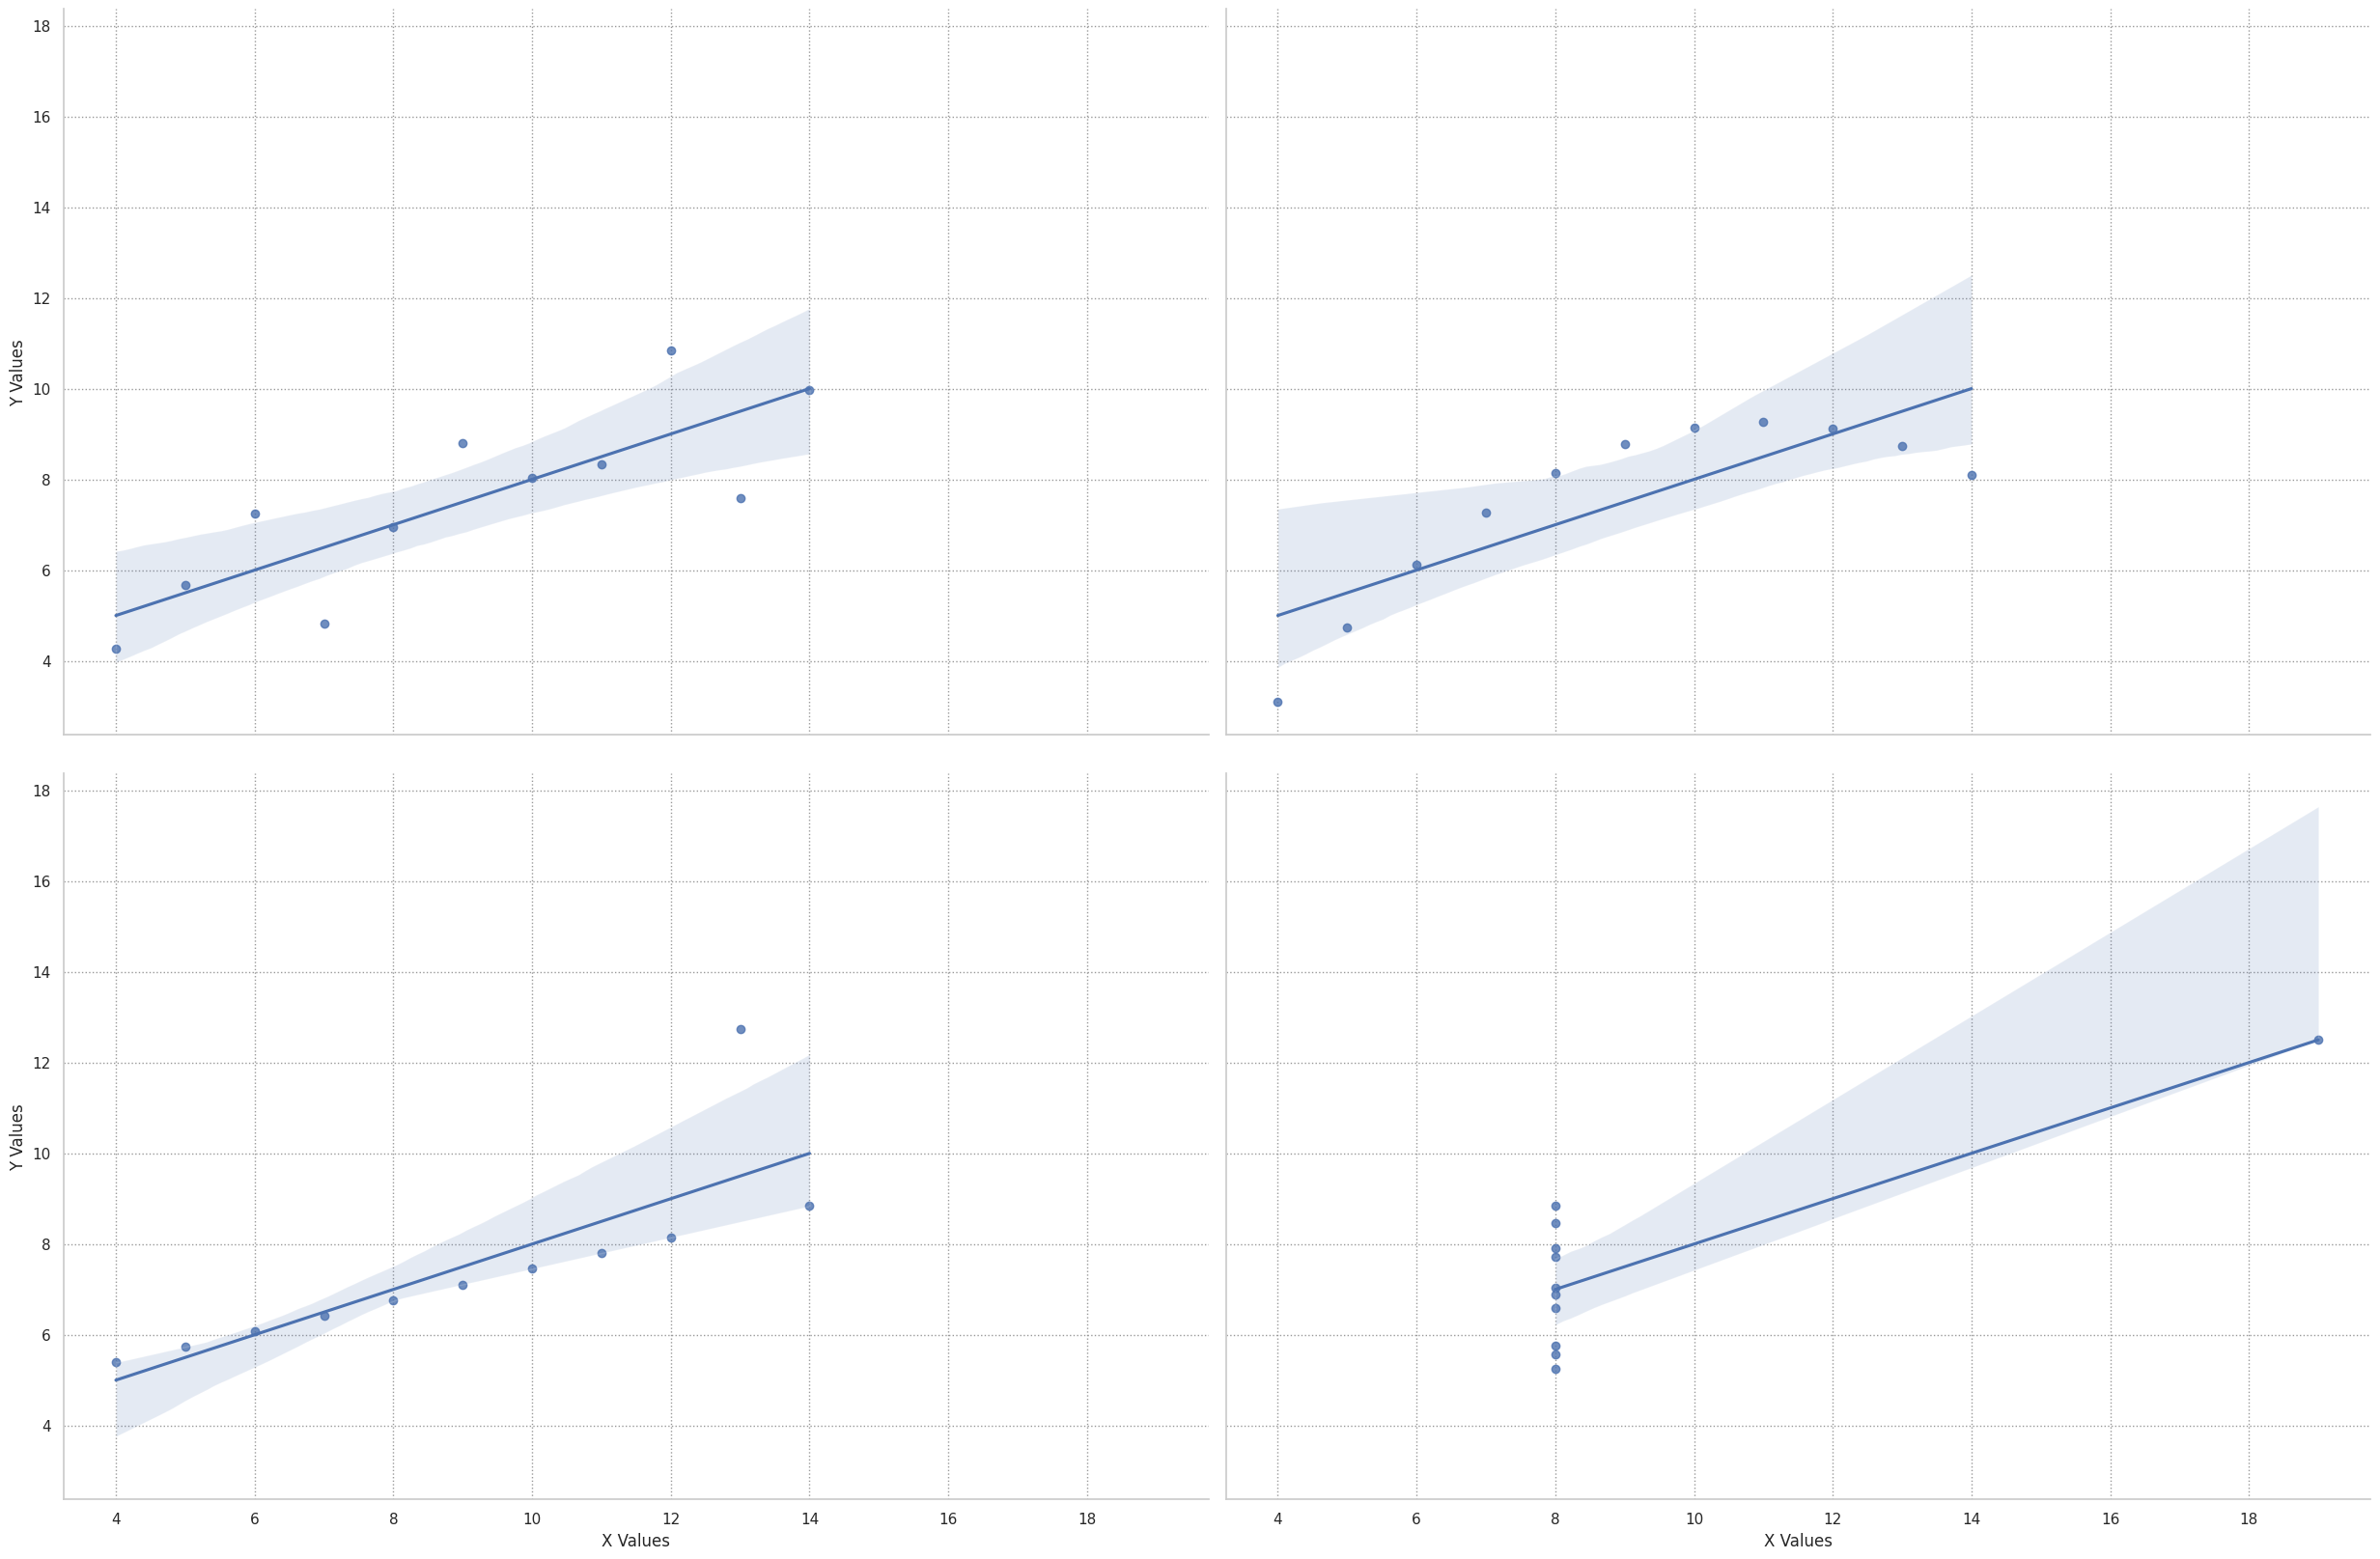

In [146]:
from scipy.stats import pearsonr
# construct Anscombe's arrays
x = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5, 10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5, 10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5, 8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68, 9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74, 7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73, 6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]
dataset = ["I"]*11 + ["II"]*11 + ["III"]*11 + ["IV"]*11
df = pd.DataFrame({"X Values": x, "Y Values": y, "Dataset": dataset})

df["row"] = ["First"]*22 + ["Second"]*22
df["col"] = ["First"]*11 + ["Second"]*11 + ["First"]*11 + ["Second"]*11

g = sb.FacetGrid(df, row="row", col="col", height=8.27, aspect=1.5)
g.map(sb.regplot, "X Values", "Y Values")
g.set_titles("")

# perform linear regressions on the datasets
slr1 = sm.OLS(df["Y Values"][df["Dataset"] == "I"], sm.add_constant(df["X Values"][df["Dataset"] == "I"])).fit()
slr2 = sm.OLS(df["Y Values"][df["Dataset"] == "II"], sm.add_constant(df["X Values"][df["Dataset"] == "II"])).fit()
slr3 = sm.OLS(df["Y Values"][df["Dataset"] == "III"], sm.add_constant(df["X Values"][df["Dataset"] == "III"])).fit()
slr4 = sm.OLS(df["Y Values"][df["Dataset"] == "IV"], sm.add_constant(df["X Values"][df["Dataset"] == "IV"])).fit()

# print the stats for the four datasets
print("Coefficients:", slr1.params.tolist(), slr2.params.tolist(), slr3.params.tolist(), slr4.params.tolist())
print("Pearson r:", pearsonr(df["X Values"][df["Dataset"] == "I"], df["Y Values"][df["Dataset"] == "I"])[0], pearsonr(df["X Values"][df["Dataset"] == "II"], df["Y Values"][df["Dataset"] == "II"])[0], pearsonr(df["X Values"][df["Dataset"] == "III"], df["Y Values"][df["Dataset"] == "III"])[0], pearsonr(df["X Values"][df["Dataset"] == "IV"], df["Y Values"][df["Dataset"] == "IV"])[0])
print("R-squared:", slr1.rsquared, slr2.rsquared, slr3.rsquared, slr4.rsquared)